# D5 fat inflation

In [113]:
import sympy
import numpy as np
import inflatox
sympy.init_printing()

In [114]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#A4 tufte layout paper figure sizes
MARGIN_FIG = lambda scale: (1.99, 1.99*scale)
MAIN_FIG = lambda scale: (4.18, 4.18*scale)
FULL_FIG = lambda scale: (6.64, 6.64*scale)

#Fontsize configuration
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', family='JetBrains Mono')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Other matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

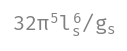

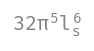

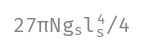

In [115]:
r, θ = sympy.symbols('r θ')
fields = [r, θ]

gs, ls, N = sympy.symbols('g_s l_s N')
mu5, T5, Lt = sympy.symbols('mu5 T5 L_T')

mu5 = (2 * sympy.pi)**5 * ls**6
T5 = mu5 / gs
Lt = (((27 * sympy.pi) / 4) * N * gs * ls**4).nsimplify()

display(T5, mu5, Lt)

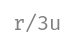

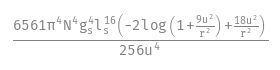

In [116]:
rho, u = sympy.symbols('rho u')
rho = r / (3*u)

H = (Lt / (3*u))**4 * ((2 / (rho**2)) - 2*sympy.ln((1/(rho**2)) +1))
display(rho, H)

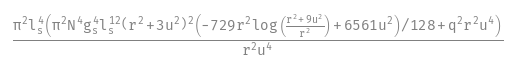

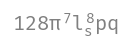

In [117]:
p, q = sympy.symbols('p q')

F = (H / 9 * (r**2 + 3*u**2)**2 + (sympy.pi*q*ls**2)**2).nsimplify().simplify()
gamma = 4*sympy.pi**2*ls**2*p*q*T5*gs
display(F, gamma)

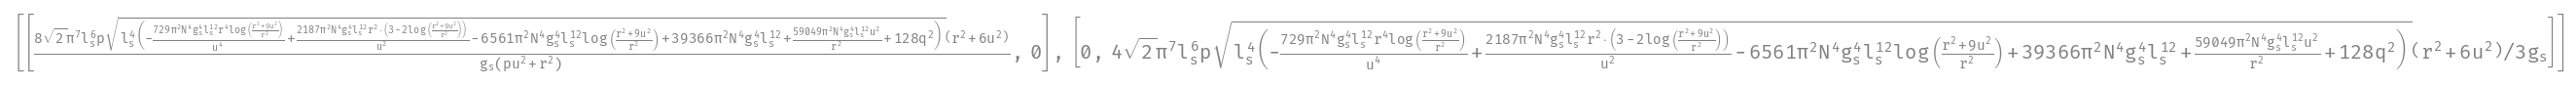

In [119]:
metric = [
  [(4*sympy.pi*p*T5*sympy.sqrt(F)*((r**2+6*u**2)/(r**2+p*u**2))).expand().simplify(), 0],
  [0, (4*sympy.pi*p*T5*sympy.sqrt(F)*(r**2+6*u**2)/6).expand().simplify()]
]
display(metric)

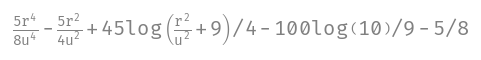

In [120]:
Phi_min = ( (5/72) * (
  81*(9*rho**2 - 2)*rho**2 +
  162*sympy.ln(9*(rho**2 + 1)) +
  -9 +
  -160*sympy.ln(10)
)).expand().nsimplify()
display(Phi_min)

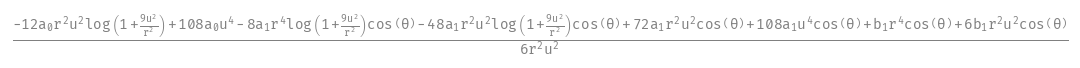

In [123]:
a0, a1, b1 = sympy.symbols('a0 a1 b1')
Phi_h = (a0 * (2/rho**2 -2*sympy.ln(1/rho**2 + 1))
  + 2*a1*(
    6 + 1/rho**2 -2*(2+3*rho**2)*sympy.ln(1 + 1/rho**2)
  )*sympy.cos(θ)
  + (b1/2) * (2+3*rho**2)*sympy.cos(θ)
).expand().cancel()
display(Phi_h)

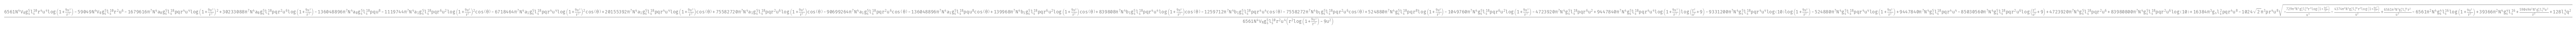

In [126]:
V0, VN = sympy.symbols('V0 V_N')
V = (1/VN) * (
  V0 
  + (4*sympy.pi*p*T5/H) * (sympy.sqrt(F)-(ls**2)*sympy.pi*q*gs)
  + gamma*(Phi_min + Phi_h)
).expand().factor().cancel()
display(V)

In [127]:
hesse = inflatox.SymbolicCalculation.new_from_list(
  fields,
  metric,
  V,
  assertions=False,
  simplification_depth=0,
  silent=True
).execute([[0,1]])

Calculating covariant Hesse matrix...
Projecting the Hesse matrix on the vielbein basis...


In [128]:
out = inflatox.Compiler(hesse, cleanup=False).compile()
out.print_sym_lookup_table()

[Symbol Dictionary]
r -> x[0]
θ -> x[1]
N -> args[0]
V0 -> args[1]
g_s -> args[2]
l_s -> args[3]
u -> args[4]
a0 -> args[5]
p -> args[6]
q -> args[7]
a1 -> args[8]
b1 -> args[9]
V_N -> args[10]


In [129]:
from inflatox.consistency_conditions import AnguelovaLazaroiuCondition
anguelova = AnguelovaLazaroiuCondition(out)

V0 = -9.630842975490789e+31
N = 1000.0
gs = 0.01
ls = 501.961
u = 50*ls
q=1.0
p=5.0
a0=0.001
a1=0.0005
b1=0.001
VN=1e40

parameters = np.array([N, V0, gs, ls, u, a0, p, q, a1, b1, VN])
print(len(parameters))

11


In [130]:
r_start, r_stop = 10.0, 25
t_start, t_stop = 0.0, 4*np.pi
extent1 = (t_start, t_stop, r_start, r_stop)

array1 = anguelova.evaluate(parameters, *extent1, N_x0=1000, N_x1=1000)

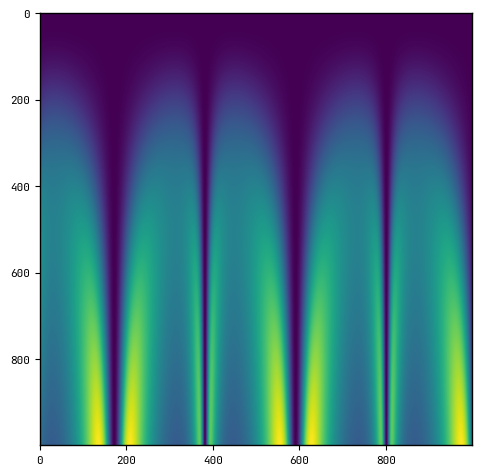

In [132]:
plt.imshow(array1)
plt.show()

In [138]:
two_norm = mpl.colors.TwoSlopeNorm(0.25, vmax=10)
cmap = mpl.colormaps['coolwarm'].copy()
cmap.set_over(cmap(1.0))
cmap.set_bad(cmap(1.0))

fig = plt.figure(figsize=MAIN_FIG(1))
ax = fig.gca()
img = ax.imshow(
  array1,
  extent=extent1,
  cmap=cmap,
  norm=two_norm,
  aspect='equal'
)

#Make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(
  img,
  extend='max',
  location='right',
  ticks=[1/100, 1/10, 1/5, 1, 5, 10],
  cax=cax
)
cax.set_yticklabels(['1/100','1/10','1/5', '1', '5', '10'])

ax.set_xlabel(f'${sympy.latex(fields[0])}$')
ax.set_ylabel(f'${sympy.latex(fields[1])}$')
fig.savefig('../out/d5fat.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig.show()

/tmp/ipykernel_8959/896070860.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [145]:
fig = plt.figure(figsize=MAIN_FIG(1))
ax = fig.gca()
img = ax.imshow(
  array1,
  extent=extent1,
  cmap=mpl.colormaps['Reds'],
  norm=mpl.colors.LogNorm(),
  aspect='equal'
)

#Make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(
  img,
  location='right',
  cax=cax
)

ax.set_xticks(
  [0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi],
  labels=['0', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$']
)

ax.set_ylabel(f'${sympy.latex(fields[0])}$')
ax.set_xlabel(f'${sympy.latex(fields[1])}$')
fig.savefig('../out/d5fat-nonnorm.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig.show()

/tmp/ipykernel_8959/380545787.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 418x438.9 with 0 Axes>

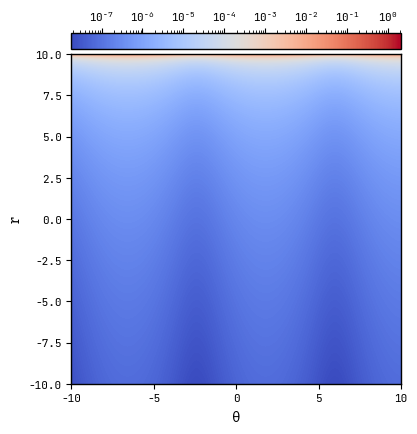

In [ ]:
plt.figure(figsize=MAIN_FIG(1.05))
img = plt.imshow(
  anguelova.calc_V_array(parameters, [t_start, r_start], [t_stop, r_stop], [5000, 5000]),
  norm=mpl.colors.LogNorm(),
  cmap='coolwarm',
  extent=(t_start, t_stop, r_start, r_stop)
)
plt.xlabel(f'${sympy.latex(fields[1])}$')
plt.ylabel(f'${sympy.latex(fields[0])}$')

plt.set_xticks(
  [0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi],
  labels=['0', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$']
)

#Make colorbar
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("top", size="5%", pad=0.05)
fig.savefig('../out/d5fatpot.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
cbar = plt.colorbar(
  img,
  location='top',
  cax=cax
)
plt.show()

In [62]:
anguelova.calc_V(np.array([21.414, np.pi]), parameters)

9.630842975490789e+31


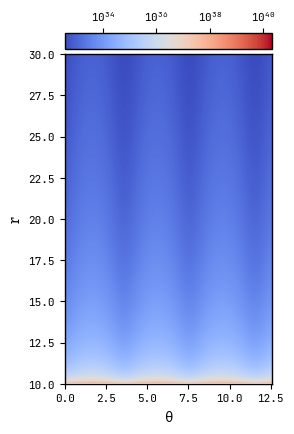

In [108]:
r_start, r_stop = 10.0, 30
t_start, t_stop = 0.0, 4*np.pi

plt.figure(figsize=MAIN_FIG(1.05))
img = plt.imshow(
  anguelova.calc_V_array(parameters, [t_start, r_start], [t_stop, r_stop], [5000, 5000]),
  norm=mpl.colors.LogNorm(),
  cmap='coolwarm',
  origin='lower',
  extent=(t_start, t_stop, r_start, r_stop)
)
plt.xlabel(f'${sympy.latex(fields[1])}$')
plt.ylabel(f'${sympy.latex(fields[0])}$')

#Make colorbar
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(
  img,
  location='top',
  cax=cax
)
plt.show()

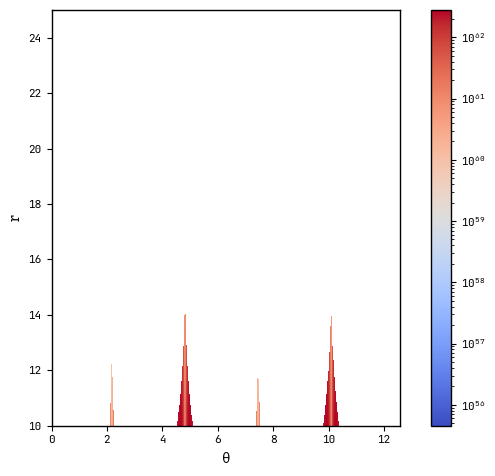

In [107]:
r_start, r_stop = 10.0, 25
t_start, t_stop = 0.0, 4*np.pi

extent1 = (t_start, t_stop, r_start, r_stop)
array1 = anguelova.evaluate(parameters, *extent1, N_x0=1000, N_x1=1000)

#plt.imshow(potential)
plt.imshow(array1,
  norm=mpl.colors.LogNorm(),
  cmap='coolwarm',
  extent=(t_start, t_stop, r_start, r_stop)
)
plt.colorbar()
plt.ylabel(f'${sympy.latex(fields[0])}$')
plt.xlabel(f'${sympy.latex(fields[1])}$')
plt.show()